In [1]:
from collections import defaultdict

import pathlib
import json

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nasbench import api

nasbench = api.NASBench('nasbench/data/nasbench_only108.tfrecord')




Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 88 seconds


In [3]:
!ls ./nasbench/data/student_data/

keys_20.json			    sokd_epoch12
search_optimal_kd_params	    sokd_epoch12_Momentum
search_optimal_kd_params_adam_opt   sokd_epoch12_SGD
search_optimal_kd_params_small_exp  students_ir0.7_t20


In [17]:
diff_configs_path = pathlib.Path("./nasbench/data/student_data/search_optimal_kd_params_adam_opt").glob("*")

accs = defaultdict(list)
times = defaultdict(list)
p_acc_correlation = {}

for conf_path in list(diff_configs_path):
    no_kd_accs = []
    for student_path in conf_path.glob("*"):
        try:
            with open(pathlib.Path(student_path, "meta.json"), 'r') as f:
                meta = json.load(f)
                acc = meta['evaluation_results'][-1]['test_accuracy']
            with open(pathlib.Path(student_path, "kd_meta.json"), 'r') as f:
                kd_meta = json.load(f)
                
            key = tuple(kd_meta.values())[:2]
            accs[key].append(acc)
            times[key].append(meta['total_time'])

            fs = nasbench.fixed_statistics[str(student_path).split('/')[-1].split("_")[-1]]
            q = nasbench.query(api.ModelSpec(matrix=fs['module_adjacency'], ops=fs['module_operations']))
            no_kd_accs.append(q['test_accuracy'])
        except Exception as e:
            print(e)
            key = tuple(kd_meta.values())[:2]
            del accs[key]
            del times[key]
    
    try:
        key = tuple(kd_meta.values())[:2]
        kd_accs = accs[key]
        pc, _ = scipy.stats.pearsonr(kd_accs, no_kd_accs)
        p_acc_correlation[key] = pc
    except Exception as e:
        print(e)
        key = tuple(kd_meta.values())[:2]
        if key in accs:
            del accs[key]
        if key in times:
            del times[key]
        if key in p_acc_correlation:
            del p_acc_correlation[key]

In [18]:
for k, v in accs.items():
    print("lmbda =", k[0], "T =", k[1], "mean_acc =", round(np.mean(v), 3))

lmbda = 0.5 T = 4.0 mean_acc = 0.675
lmbda = 0.0 T = 4.0 mean_acc = 0.683
lmbda = 0.5 T = 32.0 mean_acc = 0.664
lmbda = 1.0 T = 4.0 mean_acc = 0.104
lmbda = 1.0 T = 32.0 mean_acc = 0.099


Best: lmb: 1.0; t: 32.0; acc: 0.0992938693612814
Best: lmb: 1.0; t: 4.0; acc: 0.10350560881197453
Best: lmb: 0.5; t: 32.0; acc: 0.664377999305725
Best: lmb: 0.5; t: 4.0; acc: 0.6748147040605545
Best: lmb: 0.0; t: 4.0; acc: 0.6826622605323791


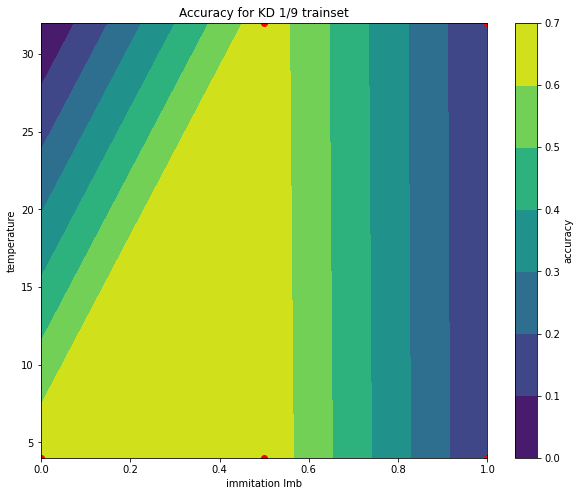

In [19]:
accs_keys = np.array(list(accs.keys()))
lmbs = list(map(float, sorted(list(set(accs_keys[:, 0])))))
ts = list(map(float, sorted(list(set(accs_keys[:, 1])), reverse=True)))

X, Y = np.meshgrid(lmbs, ts)
Z = np.zeros((len(lmbs), len(ts)))
points = []

for i, lmb in enumerate(lmbs):
    for j, t in enumerate(ts):
        if (lmb, t) in accs:
            Z[i, j] = np.mean(accs[(lmb, t)])
            points.append((lmb, t, np.mean(accs[(lmb, t)])))
            
points = np.array(points)

fig, ax = plt.subplots(figsize=(10, 8))
cs = ax.contourf(X, Y, Z.T)
cbar = plt.colorbar(cs)
cbar.set_label('accuracy')
ax.scatter(points[:, 0], points[:, 1], color='r')
ax.set_title("Accuracy for KD 1/9 trainset")
ax.set_xlabel('immitation lmb')
ax.set_ylabel('temperature')

for p in sorted(points, key=lambda x: x[-1]):
    print("Best: lmb: {}; t: {}; acc: {}".format(*p))

lmb: 1.0; t: 4.0; pearsonr: -0.24999349337081983
lmb: 1.0; t: 32.0; pearsonr: -0.029822313634944947
lmb: 0.5; t: 4.0; pearsonr: 0.7309182558003743
lmb: 0.0; t: 4.0; pearsonr: 0.7515548337404869
lmb: 0.5; t: 32.0; pearsonr: 0.7536367523789316


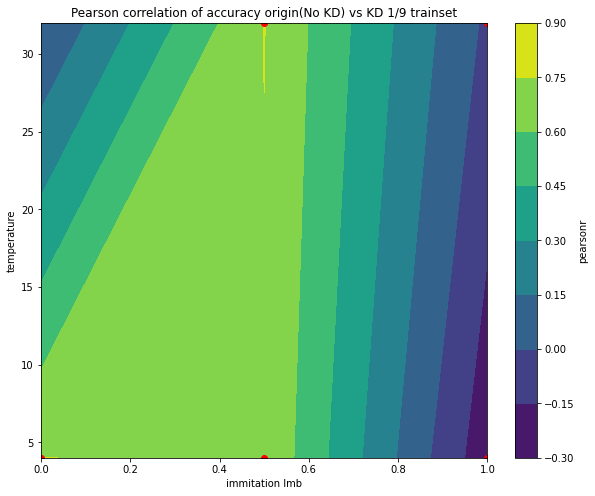

In [20]:
Z_pc = np.zeros((len(lmbs), len(ts)))

for i, lmb in enumerate(lmbs):
    for j, t in enumerate(ts):
        if (lmb, t) in accs:
            Z_pc[i, j] = p_acc_correlation[(lmb, t)]
            
fig, ax = plt.subplots(figsize=(10, 8))
cs = ax.contourf(X, Y, Z_pc.T)
cbar = plt.colorbar(cs)
cbar.set_label('pearsonr')
ax.scatter(points[:, 0], points[:, 1], color='r')
ax.set_title("Pearson correlation of accuracy origin(No KD) vs KD 1/9 trainset")
ax.set_xlabel('immitation lmb')
ax.set_ylabel('temperature')

best_result = sorted(list(p_acc_correlation.items()), key=lambda x: x[-1])
for i in range(len(best_result)):
    print("lmb: {}; t: {}; pearsonr: {}".format(best_result[i][0][0], best_result[i][0][1], best_result[i][1]))

In [ ]:
import pandas as pd

pd.DataFrame(points, columns=['lambda', 't', 'acc']).sort_values('acc', ascending=False)

In [14]:
from nasbench.lib import model_spec
import tqdm

In [15]:
stats = []

for key in tqdm.tqdm(nasbench.fixed_statistics.keys()):
    matrix = nasbench.fixed_statistics[key]['module_adjacency']
    ops = nasbench.fixed_statistics[key]['module_operations']
    spec = model_spec.ModelSpec(matrix=matrix, ops=ops)

    training_time = nasbench.query(spec)['training_time']
    test_accuracy = nasbench.query(spec)['test_accuracy']
    stats.append((key, training_time, test_accuracy))

100%|██████████| 423624/423624 [11:58<00:00, 589.97it/s]


In [17]:
sorted(stats, key=lambda x: x[1])[:10]

[('043721b9c7fe8c5fad811d47d83132ec', 285.03802490234375, 0.8359375),
 ('57d3e1b6dbaa838bbc74859c402bd77e', 472.5999755859375, 0.7259615659713745),
 ('3ae23b37681b7b34c661b643fb7e64ae', 474.70501708984375, 0.8549679517745972),
 ('03b93dfb7246c274504b4e6bb18cb727', 476.05499267578125, 0.8547676205635071),
 ('4102fbccae72145c3449756185c325ce', 476.1419982910156, 0.8488581776618958),
 ('26ef2e174bec27f4cdd42a93d92728d0', 476.9570007324219, 0.7206530570983887),
 ('6fad6b810775d4f2a2acbce0291fe544', 476.98602294921875, 0.8495593070983887),
 ('dae9d8a20cceb123c6fc5479d7b61e2a', 481.3170166015625, 0.8425480723381042),
 ('f08d0575590eb97a97cdeca3f25177b3', 481.3389892578125, 0.7444911599159241),
 ('79ac0ca945869f05b1fc34f4110f67d3', 481.36798095703125, 0.7963742017745972)]

In [5]:
nasbench.fixed_statistics["57d3e1b6dbaa838bbc74859c402bd77e"]

{'module_adjacency': array([[0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0]], dtype=int8),
 'module_operations': ['input',
  'conv1x1-bn-relu',
  'conv1x1-bn-relu',
  'conv1x1-bn-relu',
  'conv1x1-bn-relu',
  'output'],
 'trainable_parameters': 490698}